# Sampling Data -- A case study

In [3]:
# import matplotlib as mpl
%run prelude.py
mpl.rcParams['figure.figsize'] = (20,5)
XWL = np.genfromtxt("../datasets/WebLatency.csv", delimiter=",")[:,2] - 85

10496


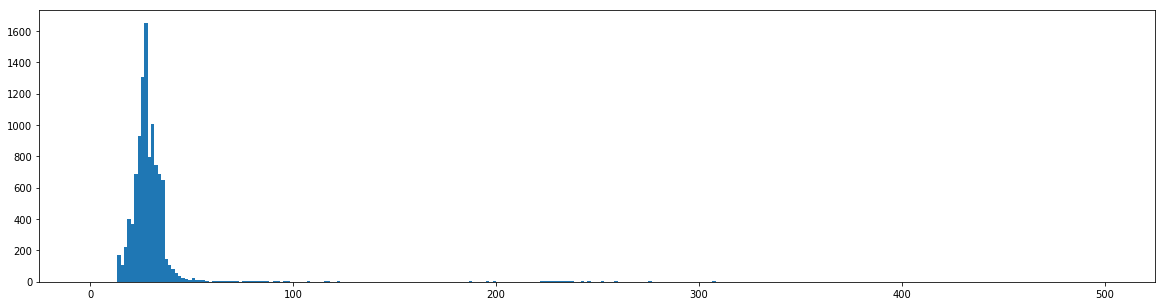

In [20]:
H("Dataset: Request Latencies")
Y = XWL
print(len(Y))
plt.hist(Y,range=(0,500),bins=300);
plt.show()
P(len(Y), "samples")

# Taking a Subsample

In [21]:
p = 0.01
def F(y): # filter function
    return np.random.random() < p

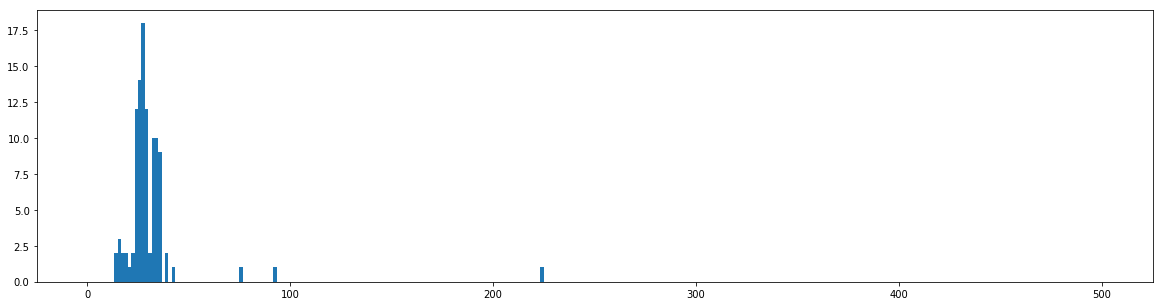

In [22]:
H("Subsample data")
SY = list(filter(F, Y))
plt.hist(SY,range=(0,500),bins=300)
plt.show()
P(len(SY),"samples")

In [23]:
# Statistics Calculated on SubSampled Data
def row(f):
    x = f(Y)
    y = f(SY)
    rerr = abs(x-y)/x*100
    return f(Y), f(SY), rerr

display(HTML(tabulate(
    [ 
        [ 'mean',  *row(lambda Y: np.mean(Y)) ],
        [ 'p50',   *row(lambda Y: np.percentile(Y, 50)) ],
        [ 'p90',   *row(lambda Y: np.percentile(Y, 90)) ],
        [ 'p99',   *row(lambda Y: np.percentile(Y, 99)) ],
        [ 'p99.9', *row(lambda Y: np.percentile(Y, 99.9)) ],
        [ 'max', *row(lambda Y: np.percentile(Y, 100)) ],
    ],
    headers = ",original data,sampled data,relative error %".split(","),
    floatfmt=".1f",
    tablefmt="html"
)))

,original data,sampled data,relative error %
mean,32.9,31.2,5.4
p50,27.2,27.8,2.2
p90,35.2,35.4,0.6
p99,222.9,92.0,58.7
p99.9,834.1,210.5,74.8
max,1453.0,224.2,84.6


TODO: Multiple runs, to estimate variance in relative error

# Discussion
- Subsampling does capture typical values very well -> mean, p50 are usually pretty accuragte

- Extremal values are not captured well. E.g. max is systemtaically underestimated from a sample

- High percentiles (0.99,0.999) can have a very large relative error

# The Bootstrap Method

...

# Statified Sampling

## Idea
- Use different probabilities for different ranges of the distribution
- Weight choosen samples by inverse probability to make-up for oversampling

## Discussion
- Can be used to reduce the high percentile errors
- Involves manual choices
- No silver bullet